In [37]:
import pandas as pd
import numpy as np
import pickle 
import warnings
import os
warnings.filterwarnings("ignore")

In [38]:
from tensorflow.python.keras import backend as k
from keras import *
from keras.preprocessing.image import *
from keras.layers import *
from keras.callbacks import *

Using TensorFlow backend.


In [39]:
def load_data_dir():
    train=pd.read_csv('train.csv')
    test=pd.read_csv('test.csv')
    
    test_dir=os.path.join('./','test_images/')
    train_dir=os.path.join('./','train_images/')
    train['file_path']=train['id_code'].map(lambda x:os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path']=test['id_code'].map(lambda x:os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name']=train['id_code'].apply(lambda x: x+ ".png")
    test['file_name']=test['id_code'].apply(lambda x: x+ ".png")
    train['diagnosis']= train['diagnosis'].astype(str)
    
    return train,test 

In [40]:
df_train,df_test=load_data_dir()
print(df_train.shape,df_test.shape)

(3662, 4) (1928, 3)


In [42]:
m1d= Sequential()
m1d.add(Conv2D(3,kernel_size=(3,3),strides=(1,1),
              activation='relu',
             input_shape=(320,320,3)))
m1d.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
m1d.add(BatchNormalization())
m1d.add(Conv2D(3,(5,5),activation='relu'))
m1d.add(MaxPooling2D(pool_size=(3,3)))
m1d.add(Flatten())
m1d.add(Dense(1000,activation='relu'))
m1d.add(Dense(5,activation='softmax'))

m1d.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=0.01),metrics=['accuracy'])

In [6]:
m1d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 318, 318, 3)       84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 159, 159, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 159, 159, 3)       12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 155, 155, 3)       228       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 51, 51, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7803)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)             

In [45]:
from sklearn.model_selection import train_test_split

df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_test.shape)

(2929, 4) (733, 4)


In [46]:
BATCH_SIZE = 8
EPOCHS = 15
WARMUP_EPOCHS = 4
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [9]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/Gray",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/Gray",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/Gray",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None
                                                     )
    
    return train_generator,valid_generator,test_generator

In [10]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [11]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [13]:
tune_g = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=15,
                                     verbose=1).history

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
293/293 [==============================] - 541s 2s/step - loss: 0.8880 - accuracy: 0.6877 - val_loss: 1.2384 - val_accuracy: 0.6849
Epoch 2/15
293/293 [==============================] - 430s 1s/step - loss: 0.7868 - accuracy: 0.7129 - val_loss: 1.1814 - val_accuracy: 0.7054
Epoch 3/15
293/293 [==============================] - 453s 2s/step - loss: 0.7656 - accuracy: 0.7167 - val_loss: 0.6566 - val_accuracy: 0.7140
Epoch 4/15
293/293 [==============================] - 443s 2s/step - loss: 0.7483 - accuracy: 0.7231 - val_loss: 0.5466 - val_accuracy: 0.6620
Epoch 5/15
293/293 [==============================] - 462s 2s/step - loss: 0.7425 - accuracy: 0.7189 - val_loss: 0.9017 - val_accuracy: 0.7140
Epoch 6/15
293/293 [==============================] - 437s 1s/step - loss: 0.7409 - accuracy: 0.7270 - val_loss: 0.3572 - val_accuracy: 0.7106
Epoch 7/15
293/293 [==============================] - 418s 1s/step - loss: 0.7364 - accuracy: 

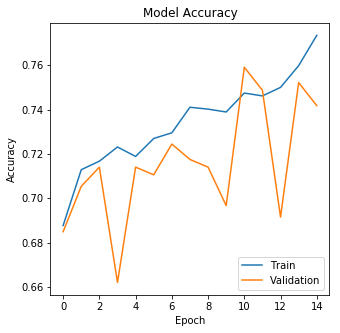

In [16]:
import matplotlib.pyplot as plot
plot.figure(figsize=(5,5))

plot.plot(tune_g['accuracy'])
plot.plot(tune_g['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

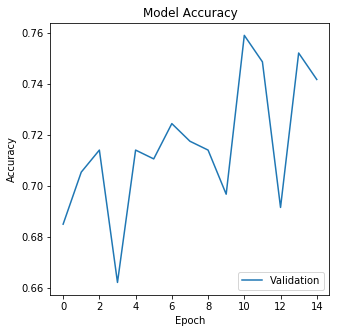

In [18]:
plot.figure(figsize=(5,5))
plot.plot(tune_g['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend([ 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

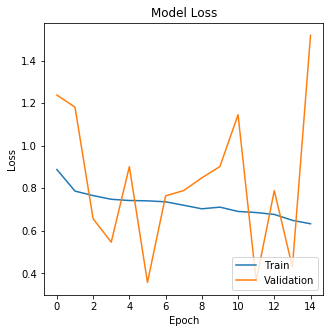

In [19]:
plot.figure(figsize=(5,5))

plot.plot(tune_g['loss'])
plot.plot(tune_g['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

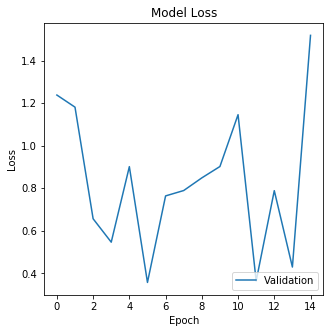

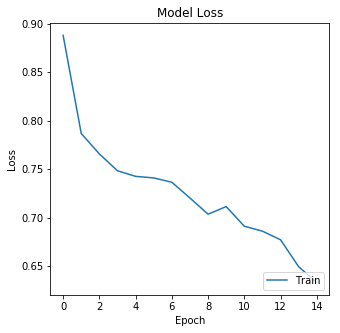

In [21]:
plot.figure(figsize=(5,5))


plot.plot(tune_g['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend([ 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

plot.figure(figsize=(5,5))
plot.plot(tune_g['loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', ], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

In [22]:
comp_datagen = ImageDataGenerator(rescale=1./255)
comp_generator = comp_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/Gray",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

stepSizeComp = comp_generator.n//comp_generator.batch_size
train_preds = m1d.predict_generator(comp_generator, steps=stepSizeComp,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 375s 128ms/step


In [23]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

cm = confusion_matrix(df_train_train['diagnosis'].astype('int'),train_preds)
train_recall = np.diag(cm) / np.sum(cm, axis = 1)
train_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall : %.3f' %np.mean(train_recall))
print('Precision : %.3f' %np.mean(train_precision ))
train_f1score= 2*(train_recall*train_precision)/(train_precision+train_recall)
print('F1 SCORE : %.3f'%np.mean(train_f1score))

Train Cohen Kappa score: 0.737
Train Accuracy score : 0.783
Recall : 0.577
Precision : 0.670
F1 SCORE : 0.590


In [25]:
test_generator.reset()
stepsizeTest = test_generator.n//test_generator.batch_size
test_preds = m1d.predict_generator(test_generator, steps=stepsizeTest,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 124s 169ms/step


In [26]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))
cm = confusion_matrix(df_train_test['diagnosis'].astype('int'),test_labels)
test_recall = np.diag(cm) / np.sum(cm, axis = 1)
test_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall :%.3f' %np.mean(test_recall))
print('Precision : %.3f'%np.mean(test_precision ))
f1score= 2*(test_recall*test_precision)/(test_precision+test_recall)
print('F1 SCORE : %.3f' %np.mean(f1score))

Test Cohen Kappa score: 0.663
Test Accuracy score : 0.726
Recall :0.474
Precision : 0.544
F1 SCORE : 0.483


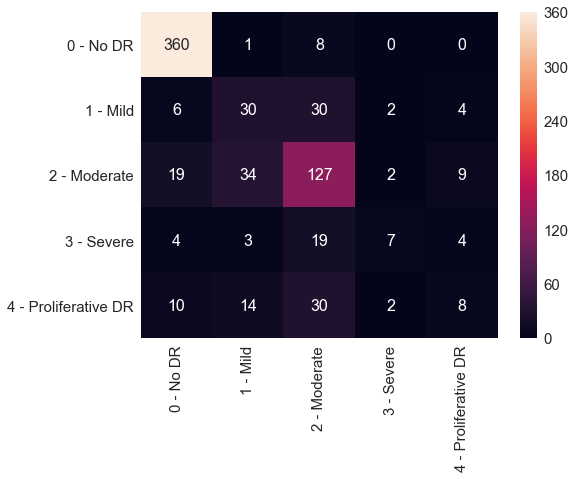

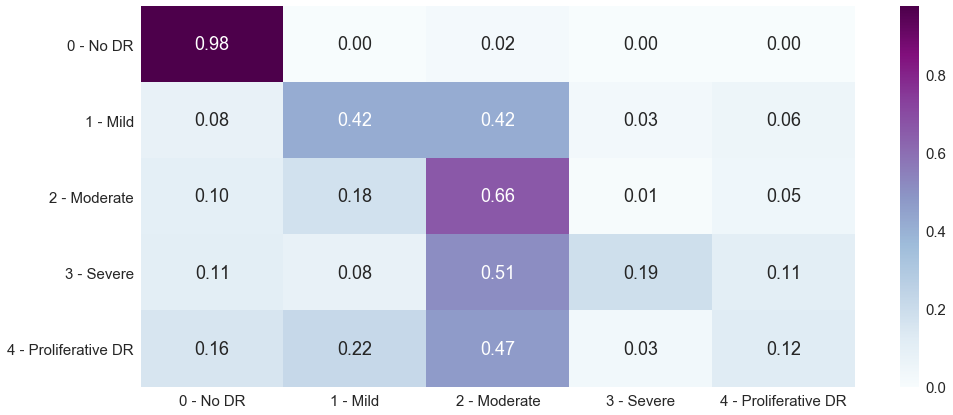

In [27]:
import seaborn as sns
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plot.figure(figsize=(8,6))
    sns.set(font_scale=1.5)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    
    plot.show()
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plot.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="BuPu")
plot.show()

In [ ]:
GREY

In [28]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None
                                                     )
    
    return train_generator,valid_generator,test_generator

In [29]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [30]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [31]:
tune_np = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=15,
                                     verbose=1).history

Epoch 1/15
293/293 [==============================] - 195s 667ms/step - loss: 0.7538 - accuracy: 0.7214 - val_loss: 0.3899 - val_accuracy: 0.7192
Epoch 2/15
293/293 [==============================] - 129s 442ms/step - loss: 0.7423 - accuracy: 0.7287 - val_loss: 1.0274 - val_accuracy: 0.7262
Epoch 3/15
293/293 [==============================] - 129s 439ms/step - loss: 0.7271 - accuracy: 0.7355 - val_loss: 0.5046 - val_accuracy: 0.7314
Epoch 4/15
293/293 [==============================] - 138s 470ms/step - loss: 0.7205 - accuracy: 0.7351 - val_loss: 0.4191 - val_accuracy: 0.7262
Epoch 5/15
293/293 [==============================] - 142s 483ms/step - loss: 0.7006 - accuracy: 0.7423 - val_loss: 1.1585 - val_accuracy: 0.7279
Epoch 6/15
293/293 [==============================] - 138s 469ms/step - loss: 0.6719 - accuracy: 0.7504 - val_loss: 0.5994 - val_accuracy: 0.7400
Epoch 7/15
293/293 [==============================] - 131s 446ms/step - loss: 0.6457 - accuracy: 0.7701 - val_loss: 0.7387 -

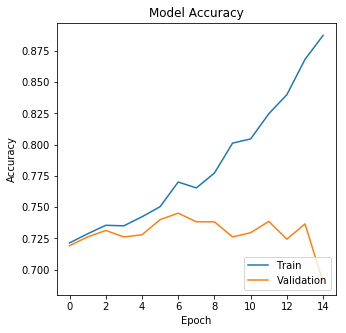

In [33]:

import matplotlib.pyplot as plot
plot.figure(figsize=(5,5))

plot.plot(tune_np['accuracy'])
plot.plot(tune_np['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()



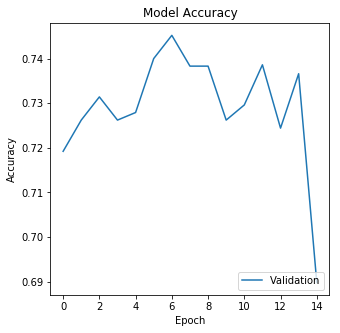

In [34]:
plot.figure(figsize=(5,5))
plot.plot(tune_np['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend([ 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

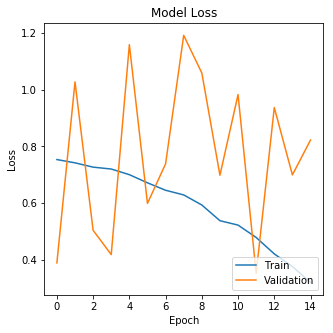

In [35]:
plot.figure(figsize=(5,5))

plot.plot(tune_np['loss'])
plot.plot(tune_np['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()


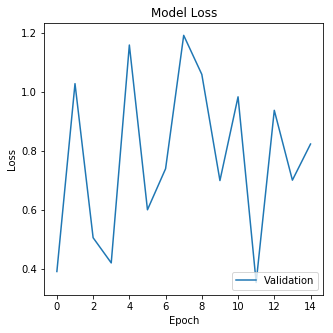

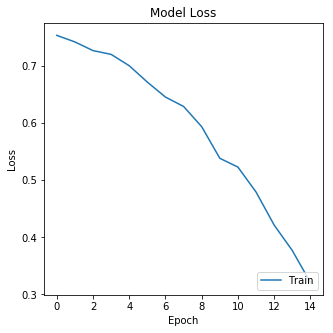

In [36]:
plot.figure(figsize=(5,5))


plot.plot(tune_np['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend([ 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

plot.figure(figsize=(5,5))
plot.plot(tune_np['loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', ], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

In [33]:
comp_datagen = ImageDataGenerator(rescale=1./255)
comp_generator = comp_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

stepSizeComp = comp_generator.n//comp_generator.batch_size
train_preds = m1d.predict_generator(comp_generator, steps=stepSizeComp,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 71s 24ms/step


In [34]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

cm = confusion_matrix(df_train_train['diagnosis'].astype('int'),train_preds)
train_recall = np.diag(cm) / np.sum(cm, axis = 1)
train_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall : %.3f' %np.mean(train_recall))
print('Precision : %.3f' %np.mean(train_precision ))
train_f1score= 2*(train_recall*train_precision)/(train_precision+train_recall)
print('F1 SCORE : %.3f'%np.mean(train_f1score))

Train Cohen Kappa score: 0.856
Train Accuracy score : 0.850
Recall : 0.748
Precision : 0.795
F1 SCORE : 0.748


In [35]:
test_generator.reset()
stepsizeTest = test_generator.n//test_generator.batch_size
test_preds = m1d.predict_generator(test_generator, steps=stepsizeTest,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 25s 34ms/step


In [38]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))
cm = confusion_matrix(df_train_test['diagnosis'].astype('int'),test_labels)
test_recall = np.diag(cm) / np.sum(cm, axis = 1)
test_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall :%.3f' %np.mean(test_recall))
print('Precision : %.3f'%np.mean(test_precision ))
f1score= 2*(test_recall*test_precision)/(test_precision+test_recall)
print('F1 SCORE : %.3f' %np.mean(f1score))

Test Cohen Kappa score: 0.643
Test Accuracy score : 0.693
Recall :0.478
Precision : 0.497
F1 SCORE : 0.471


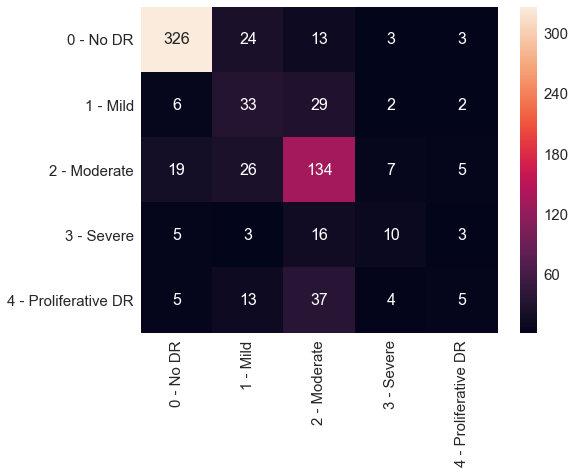

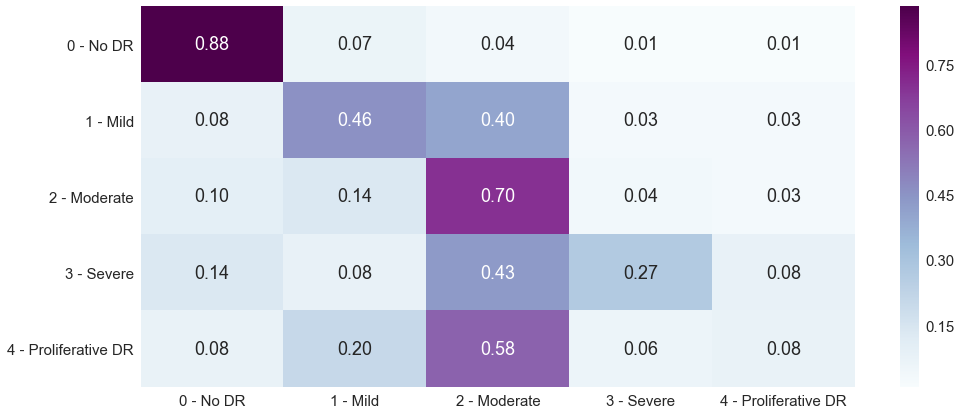

In [44]:
import seaborn as sns
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plot.figure(figsize=(8,6))
    sns.set(font_scale=1.5)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    
    plot.show()
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plot.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="BuPu")
plot.show()

In [43]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessed",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessed",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessed",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None
                                                     )
    
    return train_generator,valid_generator,test_generator

In [47]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [48]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [49]:
tune_p_sd20 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=15,
                                     verbose=1).history

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
293/293 [==============================] - 129s 439ms/step - loss: 1.1584 - accuracy: 0.6220 - val_loss: 0.9277 - val_accuracy: 0.6849
Epoch 2/15
293/293 [==============================] - 125s 427ms/step - loss: 0.8611 - accuracy: 0.6945 - val_loss: 0.8303 - val_accuracy: 0.6724
Epoch 3/15
293/293 [==============================] - 129s 439ms/step - loss: 0.8004 - accuracy: 0.7129 - val_loss: 0.5773 - val_accuracy: 0.6967
Epoch 4/15
293/293 [==============================] - 128s 436ms/step - loss: 0.7601 - accuracy: 0.7227 - val_loss: 1.0052 - val_accuracy: 0.6967
Epoch 5/15
293/293 [==============================] - 130s 445ms/step - loss: 0.7252 - accuracy: 0.7363 - val_loss: 0.4402 - val_accuracy: 0.7175
Epoch 6/15
293/293 [==============================] - 130s 444ms/step - loss: 0.6959 - accuracy: 0.7427 - val_loss: 1.1680 - val_accuracy: 0.7210
Epoch 7/15
293/293 [==============================] - 130s 443ms/step - loss

In [66]:
tune_p_sd20 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=7,
                                     verbose=1).history

Epoch 1/7
293/293 [==============================] - 121s 412ms/step - loss: 0.2022 - accuracy: 0.9352 - val_loss: 0.9681 - val_accuracy: 0.6832
Epoch 2/7
293/293 [==============================] - 125s 427ms/step - loss: 0.2033 - accuracy: 0.9428 - val_loss: 1.7418 - val_accuracy: 0.6343
Epoch 3/7
293/293 [==============================] - 126s 431ms/step - loss: 0.1775 - accuracy: 0.9497 - val_loss: 1.4005 - val_accuracy: 0.6672
Epoch 4/7
293/293 [==============================] - 126s 431ms/step - loss: 0.1619 - accuracy: 0.9599 - val_loss: 0.7262 - val_accuracy: 0.7088
Epoch 5/7
293/293 [==============================] - 129s 441ms/step - loss: 0.1303 - accuracy: 0.9659 - val_loss: 0.8047 - val_accuracy: 0.7140
Epoch 6/7
293/293 [==============================] - 133s 455ms/step - loss: 0.1260 - accuracy: 0.9765 - val_loss: 0.2831 - val_accuracy: 0.7244
Epoch 7/7
293/293 [==============================] - 224s 764ms/step - loss: 0.1019 - accuracy: 0.9782 - val_loss: 0.2253 - val_ac

In [72]:
tune_p_sd20 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=3,
                                     verbose=1).history

Epoch 1/3
293/293 [==============================] - 123s 420ms/step - loss: 0.0649 - accuracy: 0.9910 - val_loss: 1.2401 - val_accuracy: 0.7038
Epoch 2/3
293/293 [==============================] - 128s 435ms/step - loss: 0.0479 - accuracy: 0.9932 - val_loss: 0.6170 - val_accuracy: 0.7088
Epoch 3/3
293/293 [==============================] - 136s 465ms/step - loss: 0.0438 - accuracy: 0.9945 - val_loss: 0.5337 - val_accuracy: 0.7106


In [75]:
tune_p_sd20 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=3,
                                     verbose=1).history

Epoch 1/3
293/293 [==============================] - 125s 428ms/step - loss: 0.0619 - accuracy: 0.9898 - val_loss: 1.4064 - val_accuracy: 0.7055
Epoch 2/3
293/293 [==============================] - 138s 472ms/step - loss: 0.0585 - accuracy: 0.9872 - val_loss: 1.6395 - val_accuracy: 0.6880
Epoch 3/3
293/293 [==============================] - 140s 478ms/step - loss: 0.0521 - accuracy: 0.9919 - val_loss: 2.6839 - val_accuracy: 0.7175


In [78]:
tune_p_sd20 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=3,
                                     verbose=1).history

Epoch 1/3
293/293 [==============================] - 128s 437ms/step - loss: 0.0613 - accuracy: 0.9893 - val_loss: 0.4076 - val_accuracy: 0.7209
Epoch 2/3
293/293 [==============================] - 137s 466ms/step - loss: 0.0396 - accuracy: 0.9945 - val_loss: 0.0159 - val_accuracy: 0.7296
Epoch 3/3
293/293 [==============================] - 138s 472ms/step - loss: 0.0387 - accuracy: 0.9927 - val_loss: 0.5347 - val_accuracy: 0.6984


In [83]:
tune_p_sd20 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=3,
                                     verbose=1).history

Epoch 1/3
293/293 [==============================] - 121s 414ms/step - loss: 0.0482 - accuracy: 0.9923 - val_loss: 1.9079 - val_accuracy: 0.7158
Epoch 2/3
293/293 [==============================] - 125s 427ms/step - loss: 0.0476 - accuracy: 0.9906 - val_loss: 0.7563 - val_accuracy: 0.7210
Epoch 3/3
293/293 [==============================] - 127s 432ms/step - loss: 0.0358 - accuracy: 0.9932 - val_loss: 0.9470 - val_accuracy: 0.7071


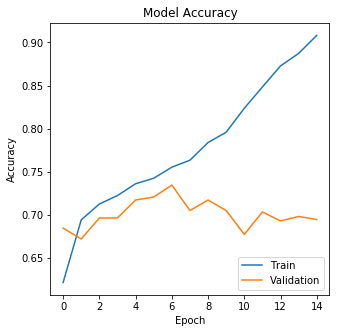

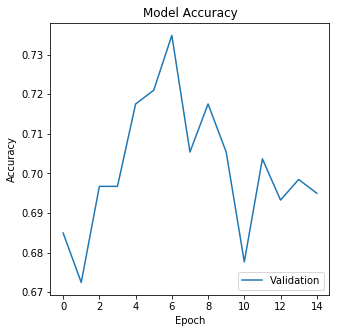

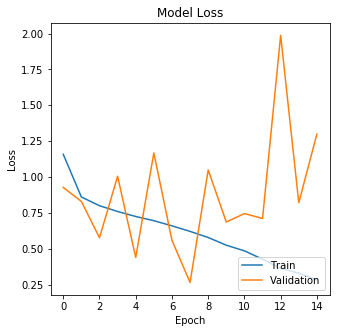

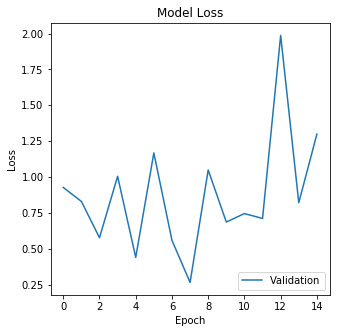

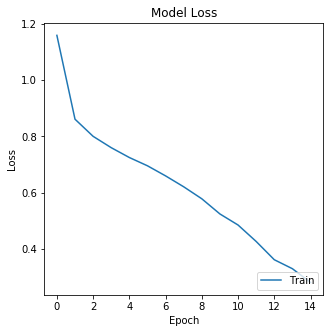

In [65]:
import matplotlib.pyplot as plot
plot.figure(figsize=(5,5))

plot.plot(tune_p_sd20['accuracy'])
plot.plot(tune_p_sd20['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

plot.figure(figsize=(5,5))


plot.plot(tune_p_sd20['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()


plot.figure(figsize=(5,5))

plot.plot(tune_p_sd20['loss'])
plot.plot(tune_p_sd20['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()


plot.figure(figsize=(5,5))


plot.plot(tune_p_sd20['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()


plot.figure(figsize=(5,5))

plot.plot(tune_p_sd20['loss'])

plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

In [52]:
comp_datagen = ImageDataGenerator(rescale=1./255)
comp_generator = comp_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessed",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

stepSizeComp = comp_generator.n//comp_generator.batch_size
train_preds = m1d.predict_generator(comp_generator, steps=stepSizeComp,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 77s 26ms/step


In [53]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

cm = confusion_matrix(df_train_train['diagnosis'].astype('int'),train_preds)
train_recall = np.diag(cm) / np.sum(cm, axis = 1)
train_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall : %.3f' %np.mean(train_recall))
print('Precision : %.3f' %np.mean(train_precision ))
train_f1score= 2*(train_recall*train_precision)/(train_precision+train_recall)
print('F1 SCORE : %.3f'%np.mean(train_f1score))

Train Cohen Kappa score: 0.880
Train Accuracy score : 0.869
Recall : 0.734
Precision : 0.860
F1 SCORE : 0.767


In [54]:
test_generator.reset()
stepsizeTest = test_generator.n//test_generator.batch_size
test_preds = m1d.predict_generator(test_generator, steps=stepsizeTest,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 20s 28ms/step


In [64]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))
cm = confusion_matrix(df_train_test['diagnosis'].astype('int'),test_labels)
test_recall = np.diag(cm) / np.sum(cm, axis = 1)
test_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall :%.3f' %np.mean(test_recall))
print('Precision : %.3f'%np.mean(test_precision ))
f1score= 2*(test_recall*test_precision)/(test_precision+test_recall)
print('F1 SCORE : %.3f' %np.mean(f1score))

Test Cohen Kappa score: 0.705
Test Accuracy score : 0.701
Recall :0.446
Precision : 0.546
F1 SCORE : 0.446


In [67]:
test_generator.reset()
stepsizeTest = test_generator.n//test_generator.batch_size
test_preds = m1d.predict_generator(test_generator, steps=stepsizeTest,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))
cm = confusion_matrix(df_train_test['diagnosis'].astype('int'),test_labels)
test_recall = np.diag(cm) / np.sum(cm, axis = 1)
test_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall :%.3f' %np.mean(test_recall))
print('Precision : %.3f'%np.mean(test_precision ))
f1score= 2*(test_recall*test_precision)/(test_precision+test_recall)
print('F1 SCORE : %.3f' %np.mean(f1score))

733/733 [==============================] - 42s 57ms/step
Test Cohen Kappa score: 0.639
Test Accuracy score : 0.644
Recall :0.471
Precision : 0.449
F1 SCORE : 0.439


In [84]:
test_generator.reset()
stepsizeTest = test_generator.n//test_generator.batch_size
test_preds = m1d.predict_generator(test_generator, steps=stepsizeTest,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]



733/733 [==============================] - 18s 25ms/step


In [88]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))
cm = confusion_matrix(df_train_test['diagnosis'].astype('int'),test_labels)
test_recall = np.diag(cm) / np.sum(cm, axis = 1)
test_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall :%.3f' %np.mean(test_recall))
print('Precision : %.3f'%np.mean(test_precision ))
f1score= 2*(test_recall*test_precision)/(test_precision+test_recall)
print('F1 SCORE : %.3f' %np.mean(f1score))


Test Cohen Kappa score: 0.696
Test Accuracy score :0.752
Recall :0.566
Precision : 0.513
F1 SCORE :0.547


In [70]:
m1d1= Sequential()
m1d1.add(Conv2D(3,kernel_size=(3,3),strides=(1,1),
              activation='relu',
             input_shape=(320,320,3)))
m1d1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
m1d1.add(BatchNormalization())
m1d1.add(Conv2D(3,(5,5),activation='relu'))
m1d1.add(MaxPooling2D(pool_size=(3,3)))
m1d1.add(Flatten())
m1d1.add(Dense(1000,activation='relu'))
m1d1.add(Dense(5,activation='softmax'))

m1d1.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.01),metrics=['accuracy'])

In [85]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))
cm = confusion_matrix(df_train_test['diagnosis'].astype('int'),test_labels)
test_recall = np.diag(cm) / np.sum(cm, axis = 1)
test_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall :%.3f' %np.mean(test_recall))
print('Precision : %.3f'%np.mean(test_precision ))
f1score= 2*(test_recall*test_precision)/(test_precision+test_recall)
print('F1 SCORE : %.3f' %np.mean(f1score))

Test Cohen Kappa score: 0.696
Test Accuracy score : 0.703
Recall :0.444
Precision : 0.513
F1 SCORE : 0.452


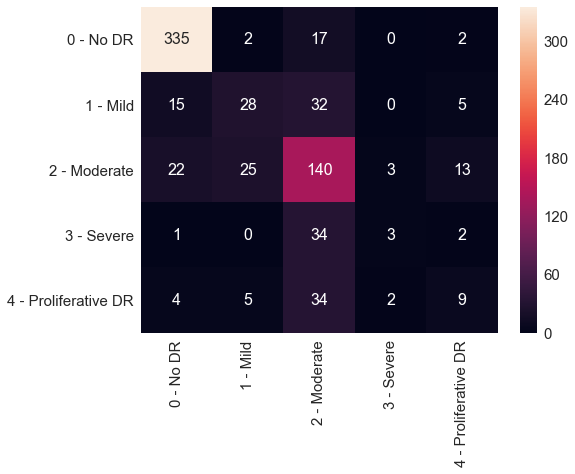

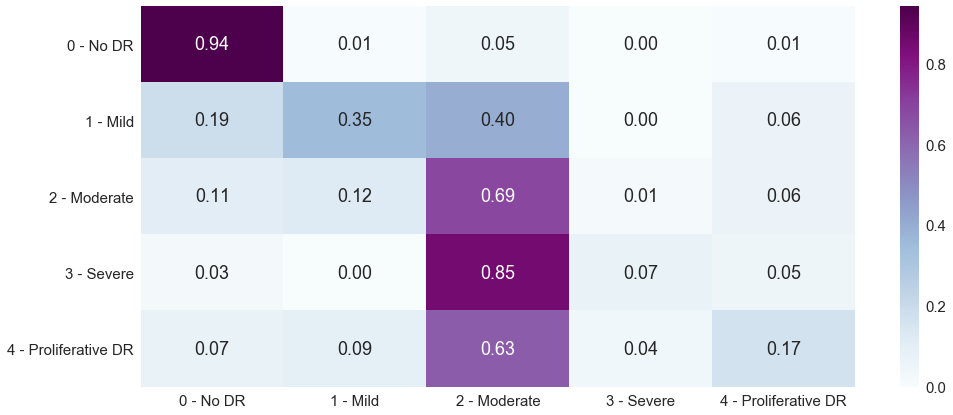

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,6))
    sns.set(font_scale=1.5)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    
    plt.show()
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="BuPu")
plt.show()

In [90]:
def crop(img,tolerance=7):
    if img.ndim==2:
        mask=img>tolerance
        return img[np_ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        mask= gray_img>tolerance
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
   
            img = np.stack([img1,img2,img3],axis=-1)

        return img

In [91]:
def circular(img,sigmax):
    img=crop(img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,d=img.shape
    x=int(w/2)
    y=int(h/2)
    z=np.amin((x,y))
    
    circle_img=np.zeros((h,w),np.uint8)
    cv2.circle(circle_img,(x,y),int(z),1,thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmax) ,-4 ,128)
    return img
    

In [96]:
import cv2
IMG_SIZE=320
def image_preprocess_save(file):
    input_filepath = os.path.join(os.getcwd(),'train_images',file)
    output_filepath = os.path.join(os.getcwd(),'train_images_preprocessedsd50',file)
    img = cv2.imread(input_filepath)
   # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE))
    img=circular(img,50)
    cv2.imwrite(output_filepath,img)

In [93]:
ya=os.listdir('train_images')

In [97]:
for i in ya:
    image_preprocess_save(i)

In [98]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessedsd50",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessedsd50",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessedsd50",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None
                                                     )
    
    return train_generator,valid_generator,test_generator

In [99]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [100]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [101]:
tune_p_sd50 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=15,
                                     verbose=1).history

Epoch 1/15
293/293 [==============================] - 151s 516ms/step - loss: 0.5670 - accuracy: 0.8067 - val_loss: 1.7294 - val_accuracy: 0.6644
Epoch 2/15
293/293 [==============================] - 128s 438ms/step - loss: 0.2696 - accuracy: 0.9070 - val_loss: 1.2034 - val_accuracy: 0.6239
Epoch 3/15
293/293 [==============================] - 129s 442ms/step - loss: 0.2027 - accuracy: 0.9369 - val_loss: 0.9435 - val_accuracy: 0.6811
Epoch 4/15
293/293 [==============================] - 129s 441ms/step - loss: 0.1524 - accuracy: 0.9539 - val_loss: 0.6425 - val_accuracy: 0.7106
Epoch 5/15
293/293 [==============================] - 125s 426ms/step - loss: 0.1179 - accuracy: 0.9714 - val_loss: 0.9316 - val_accuracy: 0.6794
Epoch 6/15
293/293 [==============================] - 125s 427ms/step - loss: 0.0951 - accuracy: 0.9723 - val_loss: 1.1163 - val_accuracy: 0.7348
Epoch 7/15
293/293 [==============================] - 126s 431ms/step - loss: 0.0993 - accuracy: 0.9782 - val_loss: 2.4124 -

In [113]:
tune_p_sd50 = m1d.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=5,
                                     verbose=1).history

Epoch 1/5
293/293 [==============================] - 124s 425ms/step - loss: 0.0305 - accuracy: 0.9932 - val_loss: 2.0893 - val_accuracy: 0.7106
Epoch 2/5
293/293 [==============================] - 132s 450ms/step - loss: 0.0354 - accuracy: 0.9927 - val_loss: 1.6019 - val_accuracy: 0.7158
Epoch 3/5
293/293 [==============================] - 133s 452ms/step - loss: 0.0353 - accuracy: 0.9932 - val_loss: 0.4765 - val_accuracy: 0.7019
Epoch 4/5
293/293 [==============================] - 129s 439ms/step - loss: 0.0422 - accuracy: 0.9923 - val_loss: 3.4326 - val_accuracy: 0.7106
Epoch 5/5
293/293 [==============================] - 131s 447ms/step - loss: 0.0252 - accuracy: 0.9945 - val_loss: 0.9678 - val_accuracy: 0.6967


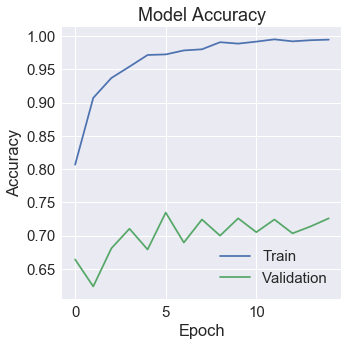

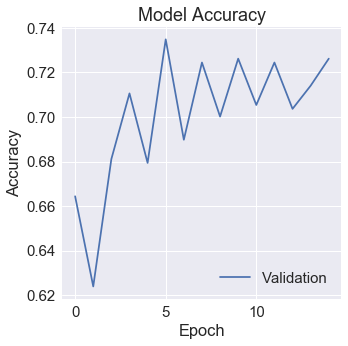

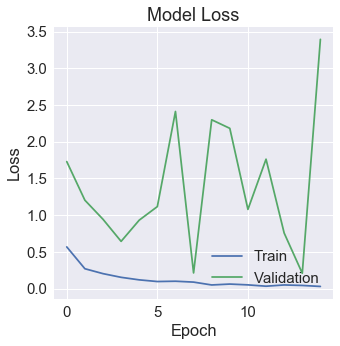

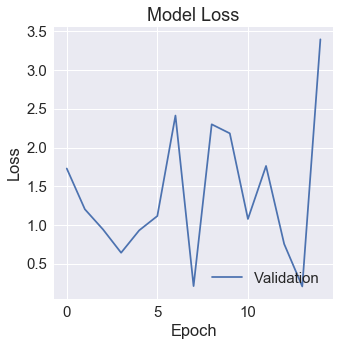

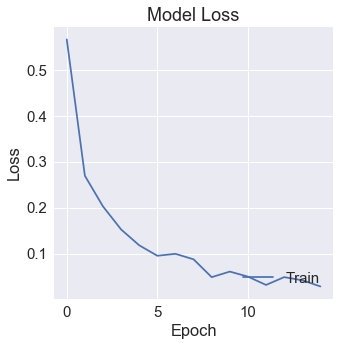

In [102]:
import matplotlib.pyplot as plot
plot.figure(figsize=(5,5))

plot.plot(tune_p_sd50['accuracy'])
plot.plot(tune_p_sd50['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

plot.figure(figsize=(5,5))


plot.plot(tune_p_sd50['val_accuracy'])
plot.title('Model Accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()


plot.figure(figsize=(5,5))

plot.plot(tune_p_sd50['loss'])
plot.plot(tune_p_sd50['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()


plot.figure(figsize=(5,5))


plot.plot(tune_p_sd50['val_loss'])
plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Validation'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()


plot.figure(figsize=(5,5))

plot.plot(tune_p_sd50['loss'])

plot.title('Model Loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train'], loc='lower right')
plot.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plot.show()

In [104]:
comp_datagen = ImageDataGenerator(rescale=1./255)
comp_generator = comp_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "C:/Users/Sabarish/Downloads/aptos2019-blindness-detection/train_images_preprocessedsd50/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

stepSizeComp = comp_generator.n//comp_generator.batch_size
train_preds = m1d.predict_generator(comp_generator, steps=stepSizeComp,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 82s 28ms/step


In [105]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

cm = confusion_matrix(df_train_train['diagnosis'].astype('int'),train_preds)
train_recall = np.diag(cm) / np.sum(cm, axis = 1)
train_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall : %.3f' %np.mean(train_recall))
print('Precision : %.3f' %np.mean(train_precision ))
train_f1score= 2*(train_recall*train_precision)/(train_precision+train_recall)
print('F1 SCORE : %.3f'%np.mean(train_f1score))

Train Cohen Kappa score: 0.947
Train Accuracy score : 0.942
Recall : 0.878
Precision : 0.927
F1 SCORE : 0.900


In [114]:
test_generator.reset()
stepsizeTest = test_generator.n//test_generator.batch_size
test_preds = m1d.predict_generator(test_generator, steps=stepsizeTest,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

733/733 [==============================] - 18s 25ms/step


In [118]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), 
                                                         weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))
cm = confusion_matrix(df_train_test['diagnosis'].astype('int'),test_labels)
test_recall = np.diag(cm) / np.sum(cm, axis = 1)
test_precision = np.diag(cm) / np.sum(cm, axis = 0)
print('Recall :%.3f' %np.mean(test_recall))
print('Precision : %.3f'%np.mean(test_precision ))
f1score= 2*(test_recall*test_precision)/(test_precision+test_recall)
print('F1 SCORE : %.3f' %np.mean(f1score))

Test Cohen Kappa score: 0.671
Test Accuracy score :0.738
Recall  :0.557
Precision :0.531
F1 SCORE :0.543


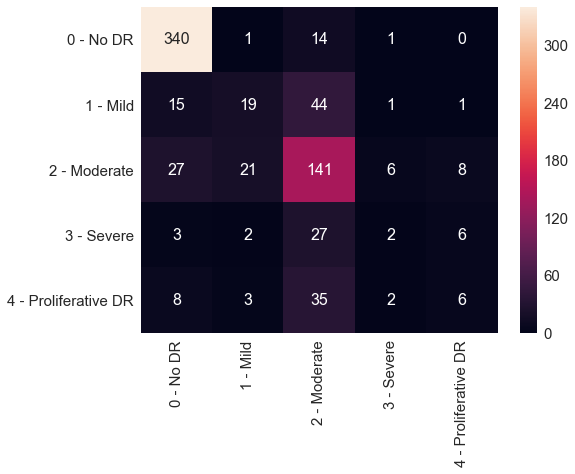

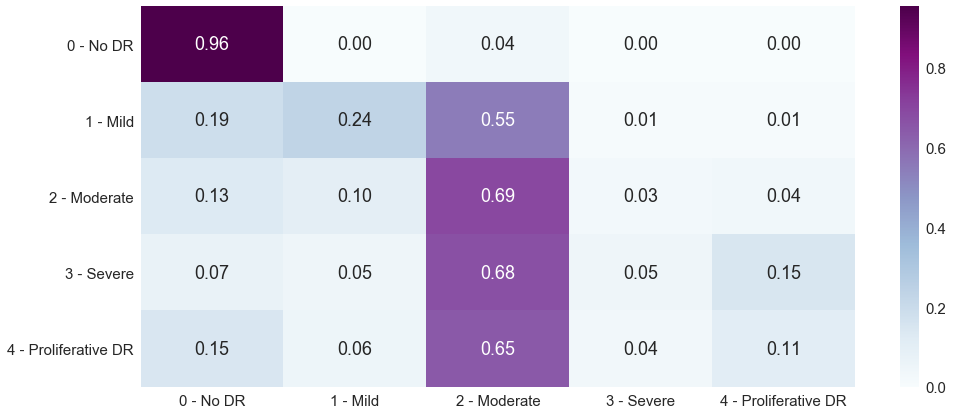

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,6))
    sns.set(font_scale=1.5)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    
    plt.show()
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="BuPu")
plt.show()

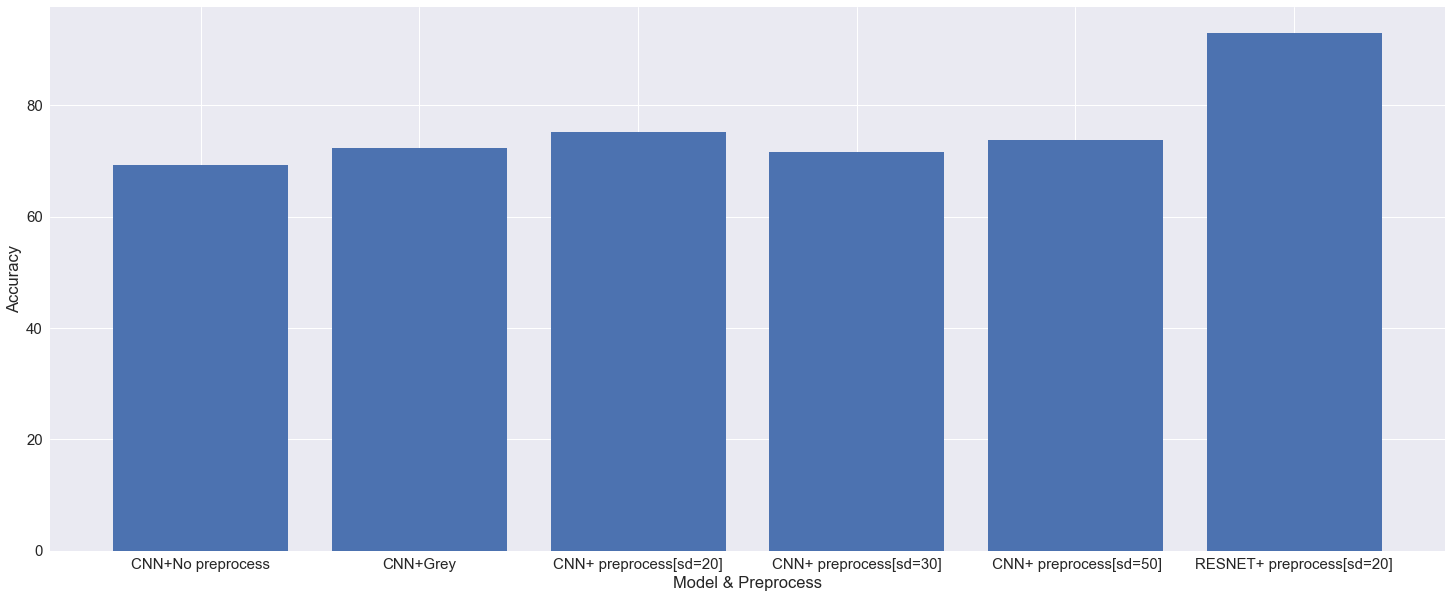

In [124]:
plot.figure(figsize=(25,10))
x=['CNN+No preprocess','CNN+Grey','CNN+ preprocess[sd=20]','CNN+ preprocess[sd=30]',' CNN+ preprocess[sd=50]','RESNET+ preprocess[sd=20]']
y=[69.3,72.4,75.2,71.6,73.8,93]
plot.ylabel('Accuracy')
plot.xlabel('Model & Preprocess')
plot.bar(x,y)
plot.show()  


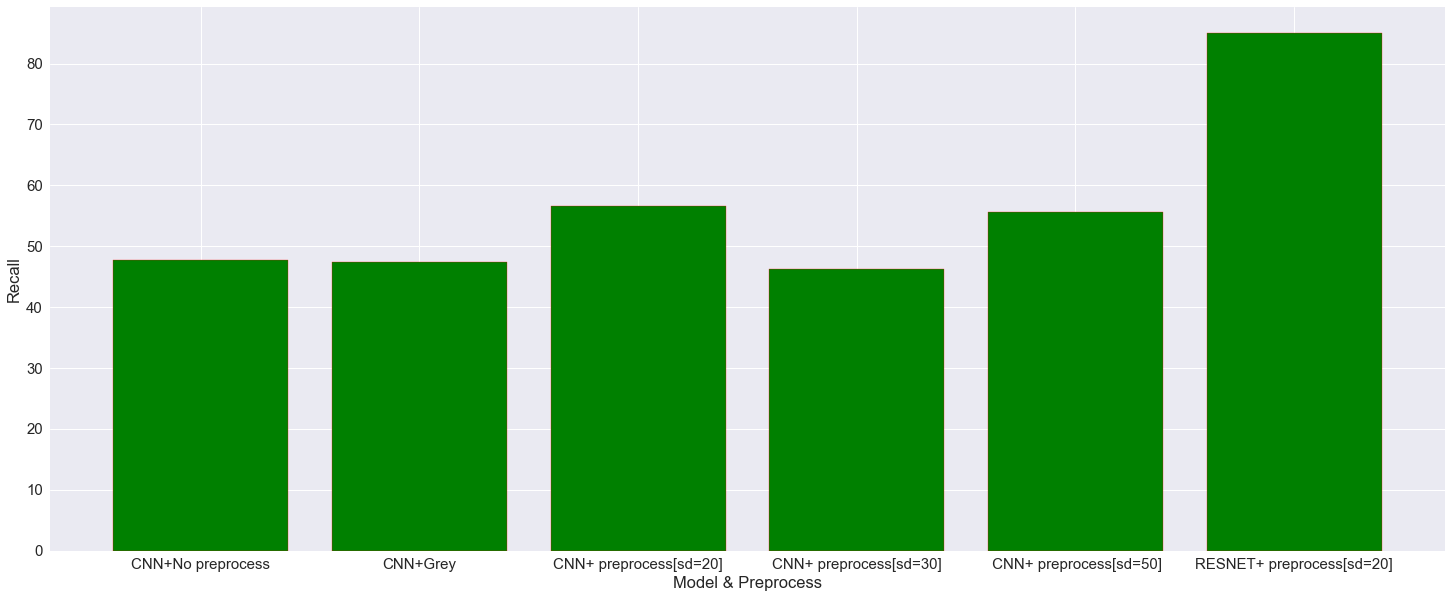

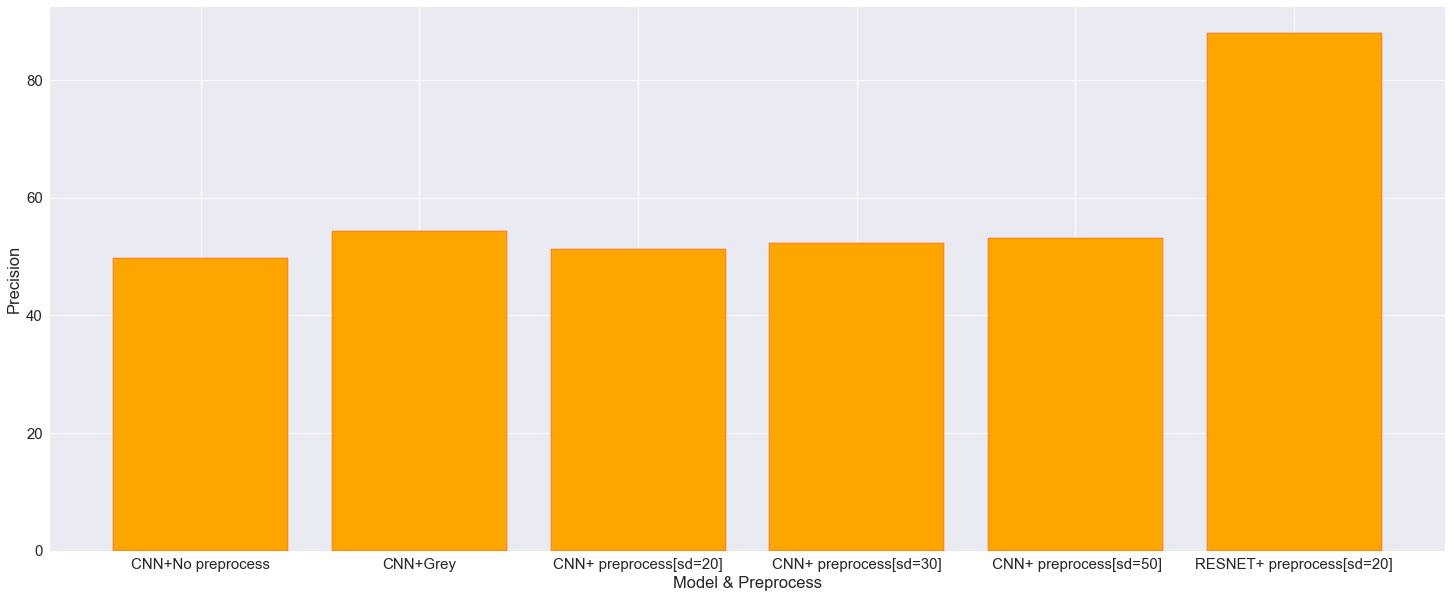

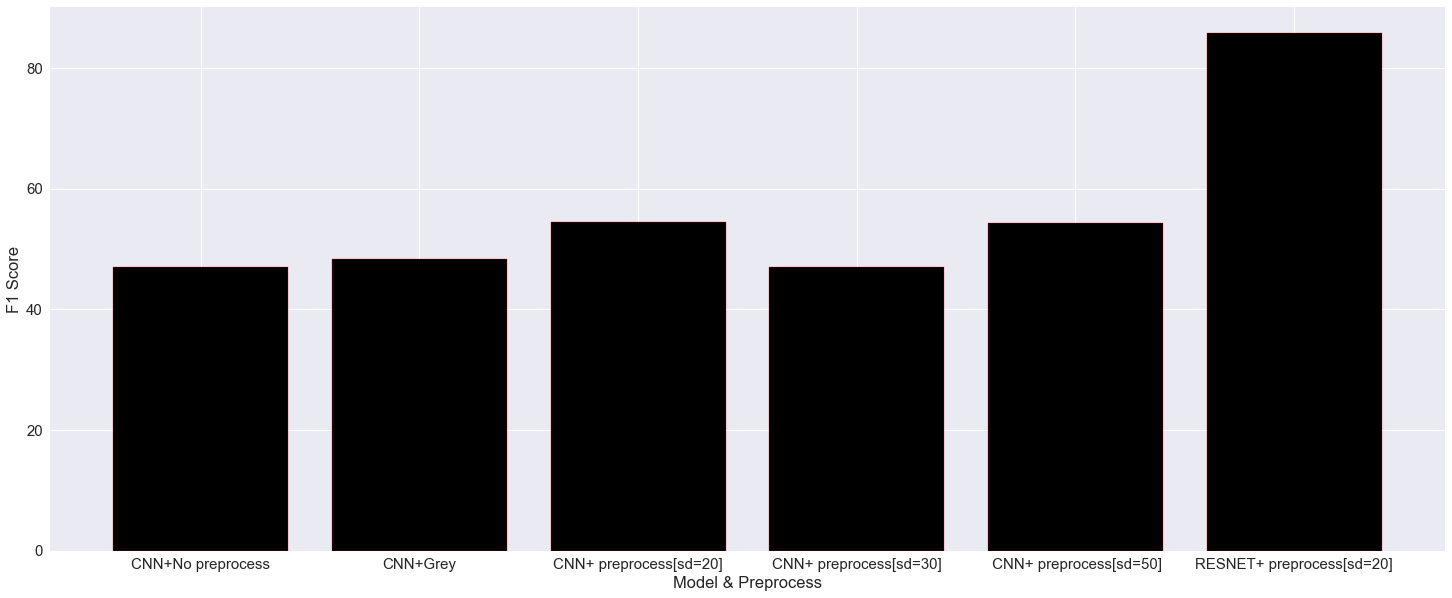

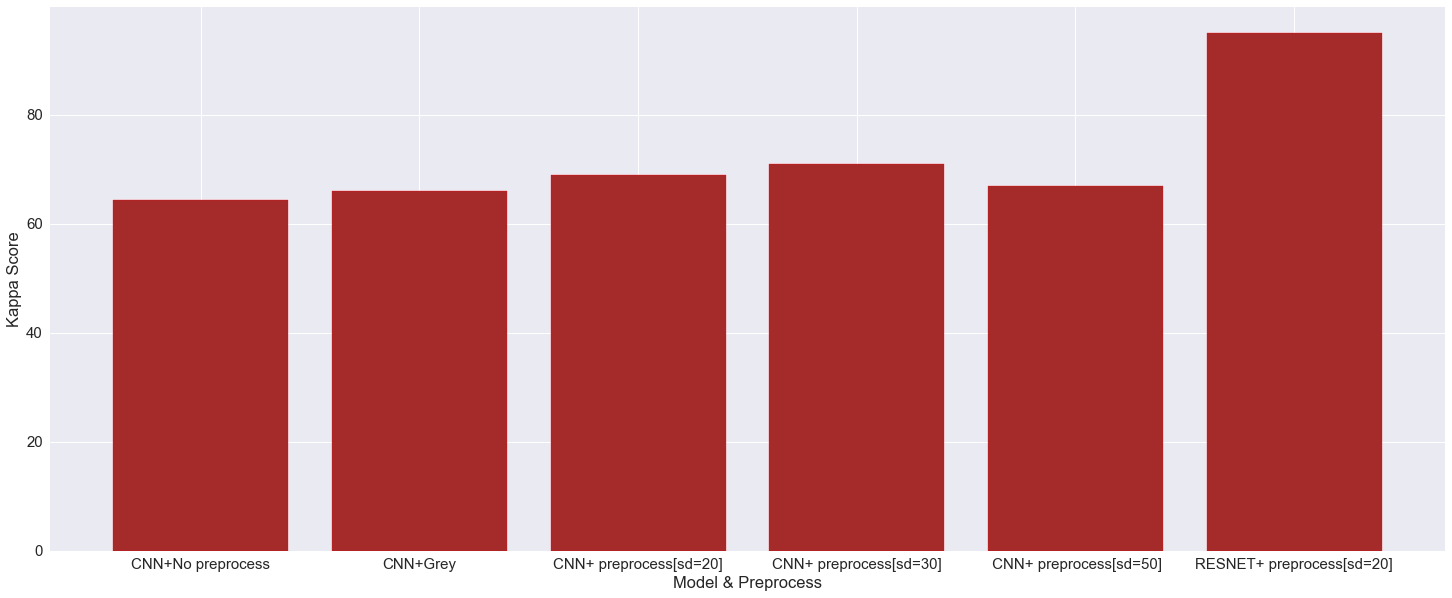

In [135]:
plot.figure(figsize=(25,10))
x=['CNN+No preprocess','CNN+Grey','CNN+ preprocess[sd=20]','CNN+ preprocess[sd=30]',' CNN+ preprocess[sd=50]','RESNET+ preprocess[sd=20]']
y=[47.8,47.4,56.6,46.3,55.7,85]
plot.ylabel('Recall')
plot.xlabel('Model & Preprocess')
plot.bar(x,y,color='green', edgecolor = 'red')
plot.show()  

plot.figure(figsize=(25,10))
x=['CNN+No preprocess','CNN+Grey','CNN+ preprocess[sd=20]','CNN+ preprocess[sd=30]',' CNN+ preprocess[sd=50]','RESNET+ preprocess[sd=20]']
y1=[49.7,54.4,51.3,52.3,53.1,88]
plot.ylabel('Precision')
plot.xlabel('Model & Preprocess')
plot.bar(x,y1,color='orange', edgecolor = 'red')
plot.show()  

plot.figure(figsize=(25,10))
x=['CNN+No preprocess','CNN+Grey','CNN+ preprocess[sd=20]','CNN+ preprocess[sd=30]',' CNN+ preprocess[sd=50]','RESNET+ preprocess[sd=20]']
y2=[47.1,48.3,54.5,47.1,54.3,85.8]
plot.ylabel('F1 Score')
plot.xlabel('Model & Preprocess')
plot.bar(x,y2,color='black', edgecolor = 'red')
plot.show()  

plot.figure(figsize=(25,10))
x=['CNN+No preprocess','CNN+Grey','CNN+ preprocess[sd=20]','CNN+ preprocess[sd=30]',' CNN+ preprocess[sd=50]','RESNET+ preprocess[sd=20]']
y2=[64.3,66,69,71,67,95]
plot.ylabel('Kappa Score')
plot.xlabel('Model & Preprocess')
plot.bar(x,y2,color='Brown', edgecolor = 'red')
plot.show()  


